## Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import math
import time
import seaborn
import os

from pyteomics import fasta
from collections import defaultdict, namedtuple

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra
from src.postprocessing import review
from src import utils
from src.scoring import scoring
from src.objects import Spectrum

# Multiple datasets post analysis
Run multiple data sets and do some post processing to see how well we do overall

### Define the data

In [2]:
def root_path():
    return os.path.abspath(os.sep)

root = root_path()


In [3]:
# define the list of datasets
# make it a list of tuples of (mzml, spectrum mill *sv, database, prefix dir)
Dataset = namedtuple(
    'Dataset', 
    ['spectra_dir', 'spectrumMill_results', 'full_database', 'highest_dir', 'filtered_fasta']
)


raw_prefix = os.path.join(root, 'Users', 'zacharymcgrath', 'Desktop', 'raw_inputs')
NOD2_top_dir = 'NOD2_E3'
BALB3_top_dir = 'BALB3_E3'


NOD2_data = Dataset(
    os.path.join(raw_prefix, NOD2_top_dir, 'mzml') + os.path.sep,
    os.path.join(raw_prefix, NOD2_top_dir, 'NOD2_E3_results.ssv'),
    os.path.join(raw_prefix, 'mouse_database.fasta'),
    os.path.join(raw_prefix, NOD2_top_dir) + os.path.sep,
    ''
)

BALB3_data = Dataset(
    os.path.join(raw_prefix, BALB3_top_dir, 'mzxml') + os.path.sep,
    os.path.join(raw_prefix, NOD2_top_dir, 'BALB3_E3.ssv'),
    os.path.join(raw_prefix, 'mouse_database.fasta') + os.path.sep, 
    os.path.join(raw_prefix, BALB3_top_dir),
    ''
)

# datasets = [NOD2_data, BALB3_data]
datasets = [NOD2_data]


### Filter the data
We don't care about the spectra that don't get matches in spectrumMill because we need something to compare to. Additionally, create a filtered database for just the proteins that are found in the results

In [4]:
def db_filter(db_file: str, results_file: str, output_fasta: str) -> None:
    '''
    Create the subset of proteins needed for the database search
    
    Inputs:
        db_file:        (str)  the original fasta file
        results_file:   (str)  the results ssv file from spectrumMill
        output_fasta:   (str)  the fasta file to write to
    '''
    
    # load all protiens into a dictionary
    db = {}
    for entry in fasta.read(db_file):
        name = entry.description.split('|')[2]
        name = name[:name.index('OS=')-1]
        name = ' '.join(name.split(' ')[1:])
        db[name.lower()] = entry

    # load the results ssv into a dataframe 
    res_df = pd.read_csv(results_file, sep=';')
        
    print(f'Number of results: {len(res_df.index)}')

    # keep track of those we want
    filtered = []
    for idx, row in res_df.iterrows():
        key = row['entry_name'].lower()
        
        if key not in db:
            continue
            
        filtered.append(db[key])

    filtered = list(set(filtered))
    
    print(f'Number of proteins in database was reduced from {len(db)} to {len(filtered)}')
    
    fasta.write(filtered, output_fasta, file_mode='w')

In [5]:
updated_datasets = []

for dataset in datasets:
        
    # make a file name for the output for the filtered fasta file
    output_fasta = os.path.join(dataset.highest_dir, 'filtered_' + dataset.highest_dir.split(os.path.sep)[-1].replace(os.path.sep, '') + '_database.fasta')
        
    # check to see if we've created it before
    if not os.path.isfile(output_fasta):
        db_filter(dataset[2], dataset[1], output_fasta)
    
    updated_datasets.append(dataset._replace(filtered_fasta=output_fasta))

datasets = updated_datasets


In [6]:
# d = pd.read_csv('/Users/zacharymcgrath/Desktop/raw inputs/BALB3_E3/BALB3_E3.ssv', sep=';')
# d.loc[d['filename'].str.contains('BALB3_E3.1.1.2')]

### Now run hyped search

In [7]:
min_pep = 3
max_pep = 30
tolerance = 20
precursor_tolerance = 10
peak_filter = 25
relative_abundance_filter = 0
cores = 16

In [8]:
for dataset in datasets:
        
    st = time.time()
    
    run_params = {
        'spectra_folder': dataset.spectra_dir,
        'database_file': dataset.filtered_fasta,
        'output_dir': os.path.join(dataset.highest_dir, 'output'),
        'min_peptide_len': min_pep,
        'max_peptide_len': max_pep,
        'tolerance': tolerance,
        'precursor_tolerance': precursor_tolerance,
        'peak_filter': peak_filter, 
        'relative_abundance_filter': relative_abundance_filter,
        'digest': 'trypsin', 
        'verbose': True,
        'DEBUG': True,
        'cores': cores,
        'truth_set': '', 
        'n': 5
    }

    runner.run(run_params)
    
    total_time = time.time() - st
    print()
    print(f'Finished. Total time was: {total_time} seconds ({total_time/60} minutes)')
    print('\n\n')

Loading database...
Done
Loading spectra...
File /Users/zacharymcgrath/Desktop/raw_inputs/NOD2_E3/mzml/.DS_Store is not of supported types (mzML, mzXML)
Done
On batch 1/1
On protein 279/279 [100%]
Sorting the set of protein masses...
Done


KeyboardInterrupt: 

### Keep track of the output data location

In [1]:
output_data = [
    os.path.join(x[3], 'output', 'summary.json') for x in datasets
]


NameError: name 'datasets' is not defined

## Total analysis (both hybrids and non hybrids)

### For each of the datasets, find out where the correct answer fell (no ties)

In [9]:
def dictify_table(df: pd.DataFrame, key: str, key_prepend: str = '') -> dict:
    '''
    Turn a pandas dataframe into a dictionary where the indices are the key specified
    '''
    ret_dict = {}
    
    prep = lambda k: key_prepend + str(k)
    
    for idx, row in df.iterrows():
        ret_dict[prep(row[key])] = dict(row)
    
    return ret_dict

In [10]:
results = defaultdict(lambda: 0)

individual_results = [defaultdict(lambda: 0) for _ in range(len(datasets))]

nf_key = 'not found'
na_key = 'no alignment'

# keep trock of the ranks keyed by id
id_keyed_results = {}

for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    nf = []
    na = []
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    print(f'Total number of SpectrumMill results: {len(specMill_results)}')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
    print(f'Total number of hyped search results: {len(hypedSearch_results)}')
        
    # index hypedSearch_results by the id value in key, value value['spectrum']
    
    # for BALB3, we need other_metadata[0]['parentFileName']    
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    else:
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        hybrid = False
        
        if 'hybrid' in value['entry_name'].lower():
            hybrid = True
        
        correct_sequence = value['sequence']
        
        
        # if hybrid, replace L and I with B
        if hybrid:
            correct_sequence = correct_sequence.replace('L', 'B').replace('I', 'B')
        
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            nf.append(key)
            results[nf_key] += 1
            individual_results[j][nf_key] += 1
            id_keyed_results[key] = nf_key
            continue 
            
        found = False
                    
        for i, alignment in enumerate(hypedSearch_results[key]['alignments']):
            
            comp_sequence = alignment['sequence']
            
            # if hybrid, replace L and I with B
            if hybrid:
                comp_sequence = comp_sequence.replace('L', 'B').replace('I', 'B')
            
            if comp_sequence == correct_sequence:
                results[str(i)] += 1
                individual_results[j][str(i)] += 1
                id_keyed_results[key] = i
                found = True
    
        if not found:
            na.append(key)
            results[na_key] += 1
            individual_results[j][na_key] += 1
            id_keyed_results[key] = na_key
    
    print(f'{len(nf)} ids not found in hypedSearch results that were found in spectrumMill')
    print(f'{len(na)} "correct" alignments from spectrumMill were not made in hyped search')
    print()
    

Total number of SpectrumMill results: 1086
Total number of hyped search results: 1086
0 ids not found in hypedSearch results that were found in spectrumMill
109 "correct" alignments from spectrumMill were not made in hyped search



### Plot it by all results (no ties)

In [11]:
sorted_int_keys = sorted([x for x in list(results.keys()) if x.isdigit()], key=lambda x: int(x))
non_int_keys = [x for x in list(results.keys()) if not x.isdigit()]

Text(0.5, 1.0, 'Number of results with a ranking for all datasets')

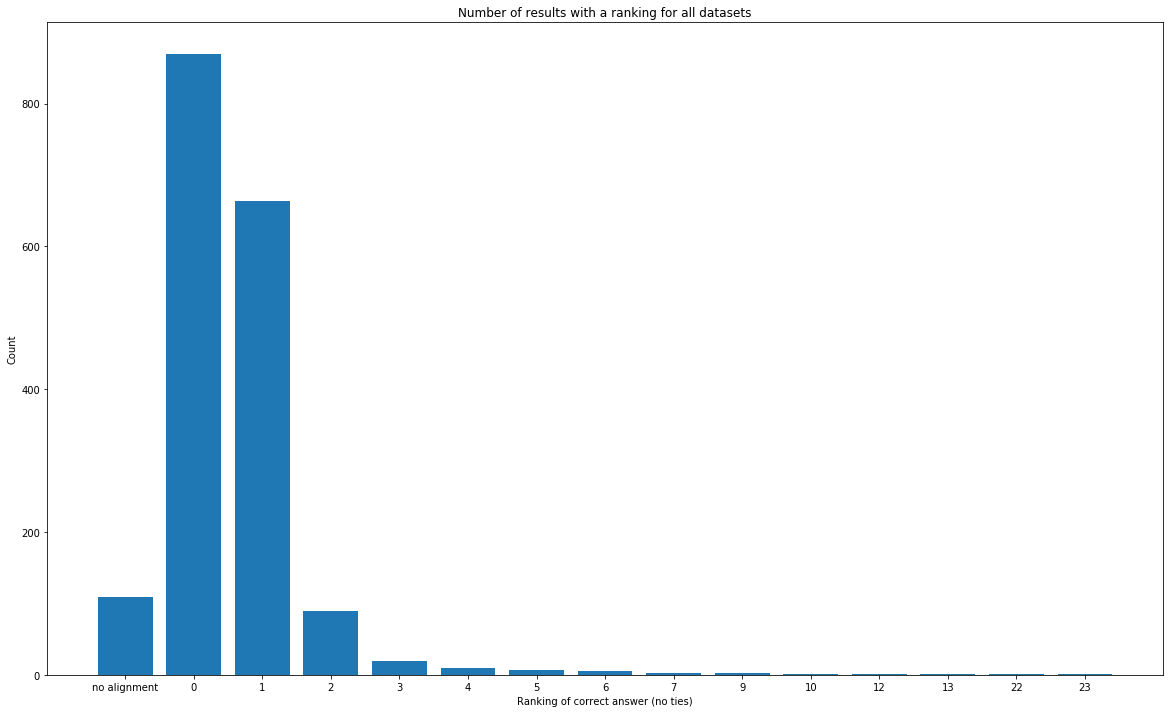

In [12]:
plt.figure(figsize=(20, 12))

plt.bar(non_int_keys + sorted_int_keys, [results[k] for k in non_int_keys] + [results[k] for k in sorted_int_keys])
plt.xlabel('Ranking of correct answer (no ties)')
plt.ylabel('Count')
plt.title('Number of results with a ranking for all datasets')

### Plot it by the dataset

TypeError: 'AxesSubplot' object is not subscriptable

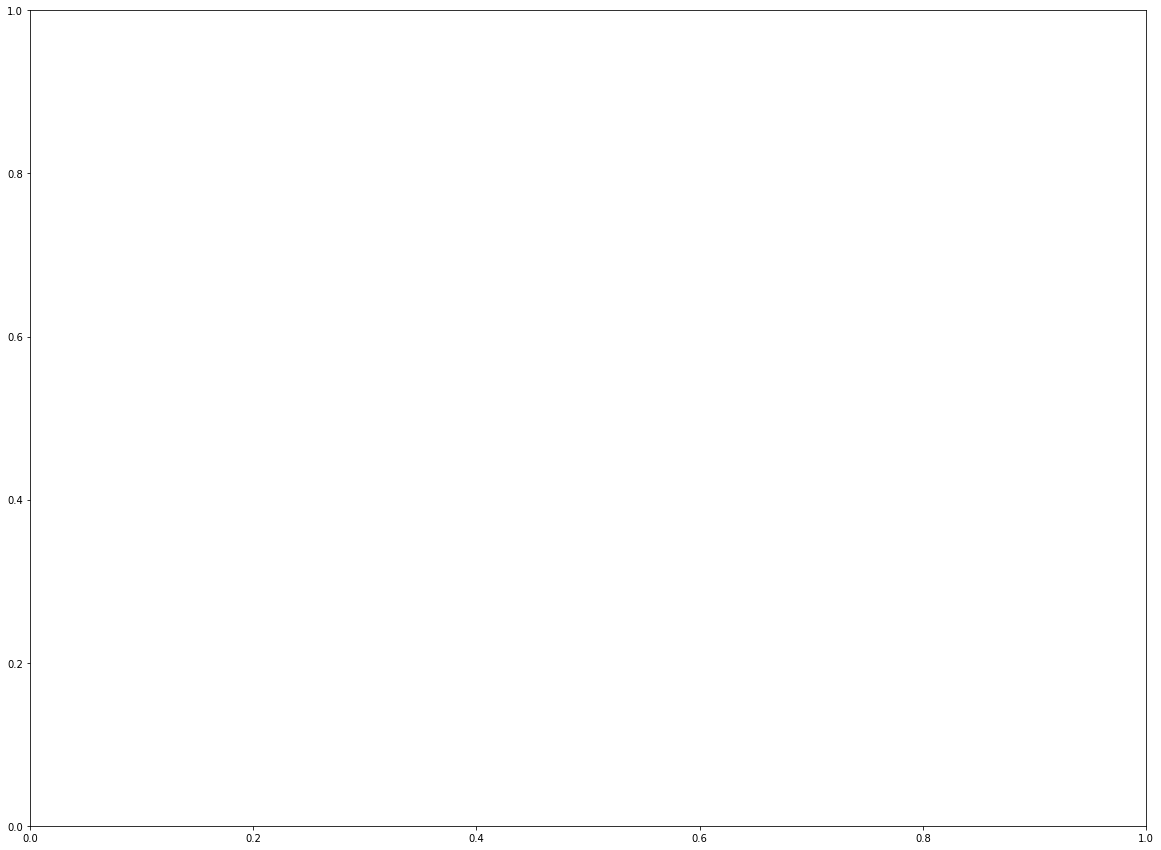

In [11]:
fig, axes = plt.subplots(len(individual_results), 1, figsize=(20, 15*len(individual_results)))

for i, ir in enumerate(individual_results):
        
    # first get the title
    dataset_name = datasets[i].highest_dir.split('/')[-2]
    title = f'Number of {dataset_name} results with ranking'
    
    # get the keys
    ir_sik = sorted([x for x in list(ir.keys()) if x.isdigit()], key=lambda x: int(x))
    ir_nik = [x for x in list(ir.keys()) if not x.isdigit()]
    
    axes[i].bar(ir_nik + ir_sik, [ir[k] for k in ir_nik] + [ir[k] for k in ir_sik])
    
    axes[i].set_title(title)
    axes[i].set_xlabel('Ranking of correct answer (no ties)')
    axes[i].set_ylabel('Count')
    
    all_res = sum([v for _, v in ir.items()])
    
    print(f'{all_res} results for {dataset_name}')

### For each of the datasets, find out where the correct answer fell (with ties)

In [12]:
results = defaultdict(lambda: 0)

individual_results = [defaultdict(lambda: 0) for _ in range(len(datasets))]

nf_key = 'not found'
na_key = 'no alignment'

for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    nf = []
    na = []
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
    
    # BALB dataset id found in another location
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
    else:
        # index hypedSearch_results by the id value in key, value value['spectrum']
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    
    
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        hybrid = False
        
        if 'hybrid' in value['entry_name'].lower():
            hybrid = True
        
        correct_sequence = value['sequence']
        
        # if hybrid, replace L and I with B
        if hybrid:
            correct_sequence = correct_sequence.replace('L', 'B').replace('I', 'B')
        
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            nf.append(key)
            results[nf_key] += 1
            individual_results[j][nf_key] += 1
            continue 
            
        found = False
        
        # since we can allow for ties, we need to bin by the scores
        scores = defaultdict(list)
                    
        for i, alignment in enumerate(hypedSearch_results[key]['alignments']):
            
            comp_sequence = alignment['sequence']
            
            # bin it 
            scores[alignment['total_score']].append(alignment)
            
            # if hybrid, replace L and I with B
            if hybrid:
                comp_sequence = comp_sequence.replace('L', 'B').replace('I', 'B')
            
            if comp_sequence == correct_sequence:
                # the correct result rank is the len(scores) - 1
                rank = str(len(scores) - 1)
                
                results[rank] += 1
                individual_results[j][rank] += 1
                found = True
                
        if not found:
            na.append(key)
            results[na_key] += 1
            individual_results[j][na_key] += 1
    

### Plot it by all results (with ties)

In [13]:
sorted_int_keys = sorted([x for x in list(results.keys()) if x.isdigit()], key=lambda x: int(x))
non_int_keys = [x for x in list(results.keys()) if not x.isdigit()]

Text(0.5, 1.0, 'Number of results with a ranking for all datasets')

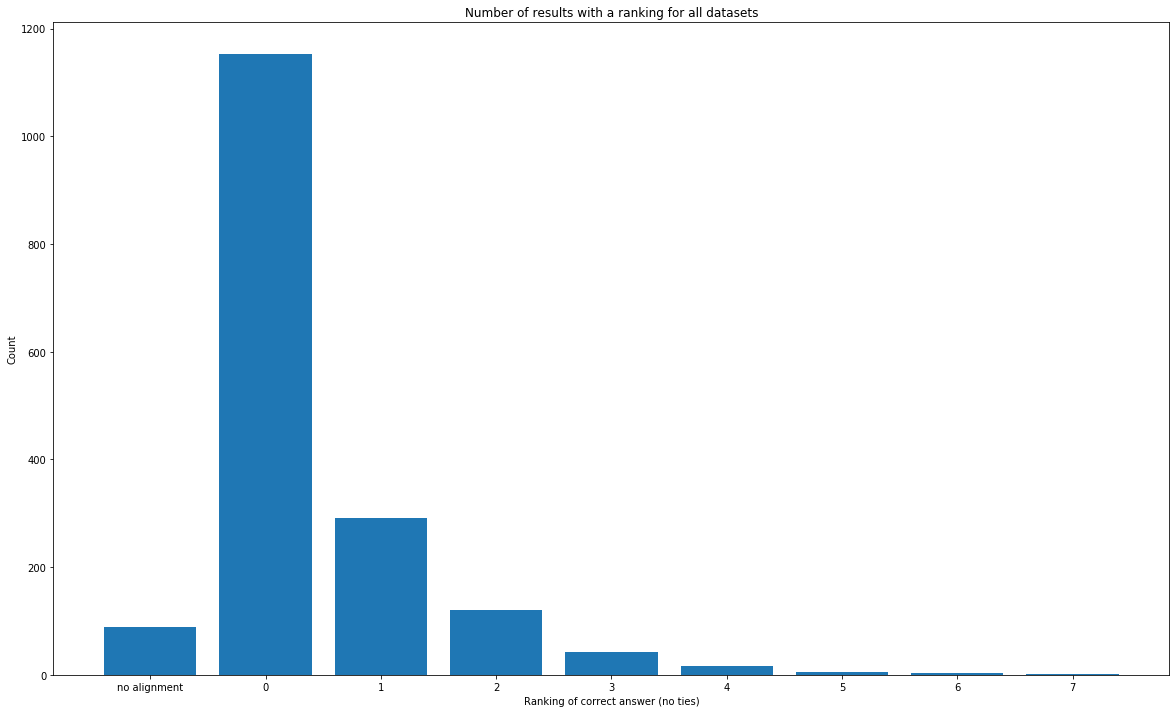

In [14]:
plt.figure(figsize=(20, 12))

plt.bar(non_int_keys + sorted_int_keys, [results[k] for k in non_int_keys] + [results[k] for k in sorted_int_keys])
plt.xlabel('Ranking of correct answer (no ties)')
plt.ylabel('Count')
plt.title('Number of results with a ranking for all datasets')

### Plot it by the dataset

TypeError: 'AxesSubplot' object is not subscriptable

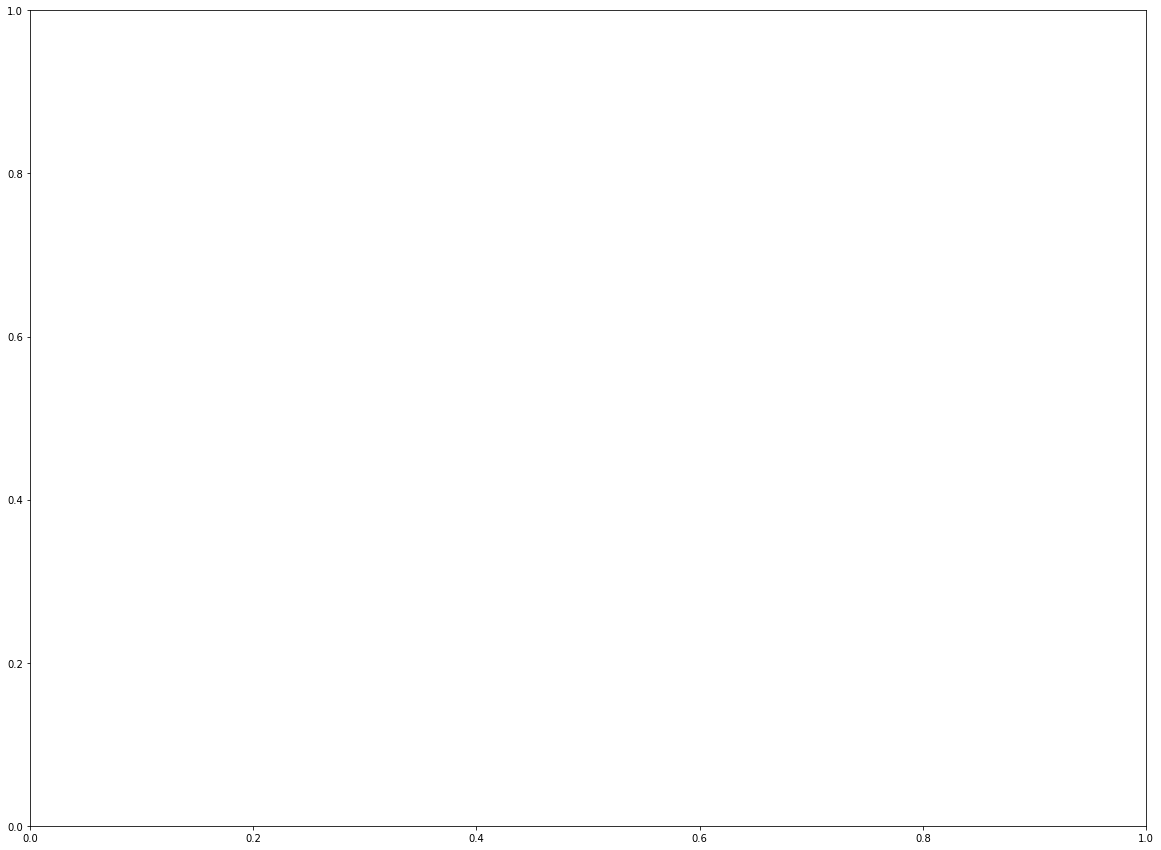

In [15]:
fig, axes = plt.subplots(len(individual_results), 1, figsize=(20, 15*len(individual_results)))

for i, ir in enumerate(individual_results):
    
    # first get the title
    title = datasets[i].highest_dir.split('/')[-2]
    title = f'Number of {title} results with ranking'
    
    # get the keys
    ir_sik = sorted([x for x in list(ir.keys()) if x.isdigit()], key=lambda x: int(x))
    ir_nik = [x for x in list(ir.keys()) if not x.isdigit()]
    
    axes[i].bar(ir_nik + ir_sik, [ir[k] for k in ir_nik] + [ir[k] for k in ir_sik])
    
    axes[i].set_title(title)
    axes[i].set_xlabel('Ranking of correct answer (no ties)')
    axes[i].set_ylabel('Count')

## Hybrid analysis

In [16]:
for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    missed = []
    all_hybs = []
    
    print(f'Looking for hybrids in the dataset {dataset.highest_dir.split("/")[-2]}\n=====================================================')
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
        
    # index hypedSearch_results by the id value in key, value value['spectrum']
    
    # for BALB3, we need other_metadata[0]['parentFileName']    
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    else:
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        # skip it if not a hybrid
        if not 'hybrid' in value['entry_name'].lower():
            continue
        
        # replace with B for easier comparison
        correct_sequence = value['sequence'].replace('L', 'B').replace('I', 'B')
        
        print(f'"Correct" hybrid sequence is {value["sequence"]}\n----------------------------------------')
    
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            print(f'Alignment not made for {key}')
            
        found = False    
        
        # try to find a match for it 
        for i, alignment in enumerate(hypedSearch_results[key]['alignments']):
            
            print(f'{alignment["sequence"]} \t {alignment["total_score"]} \t {alignment["b_score"]} \t {alignment["y_score"]} \t {alignment["total_mass_error"]}')
            
            if alignment["sequence"].replace('L', 'B').replace('I', 'B') == correct_sequence:
                found = True
                break
                
        if not found:
            missed.append(key)
            
        all_hybs.append(key)
                
        print()
        
    print(f'Missed {len(missed)}/{len(all_hybs)} hybrids for dataset {dataset.highest_dir.split("/")[-2]}')
    
    print('\n')
        
        

Looking for hybrids in the dataset NOD2_E3
"Correct" hybrid sequence is DLQTLALLL
----------------------------------------
LATALTSPIL 	 7 	 4 	 3 	 0.007249227500011557
LATALTSPLL 	 7 	 4 	 3 	 0.007249227500011557
LATALTSPII 	 7 	 4 	 3 	 0.007249227500011557
LATALTSPLI 	 7 	 4 	 3 	 0.007249227500011557
DLQTLALII 	 7.0 	 6 	 2 	 0.007388087148399336

"Correct" hybrid sequence is DPQVAQLELGGEVEDPQVAQLELGGGPGAG
----------------------------------------
DPQVAQLELGGEVEDPQVAQLELGGGPGAG 	 11.5 	 9 	 6 	 0.016867231641015223

"Correct" hybrid sequence is DLPVNSPMTKG
----------------------------------------
LDPVNSPMTKG 	 6.5 	 2 	 5 	 0.012423040742163494
IDPVNSPMTKG 	 6.5 	 2 	 5 	 0.012423040742163494
DLPVNSPMTKG 	 6.5 	 2 	 5 	 0.012423040742163494

"Correct" hybrid sequence is DLQTLALWSRM
----------------------------------------
DLQTLALWSRM 	 12.5 	 5 	 8 	 0.02228520957024216

"Correct" hybrid sequence is DLQTLALNAAR
----------------------------------------
DLQTLALGAQR 	 12 	 4 	 8 	 0.0

## Mass error distribution
Go through all the ids. If the id had a rank of 0, skip it. We want to plot the distribution of total mass error for the OUR top alignment as well as the spectrumMill one

In [17]:
all_hypedSearch_rank_tme = []
all_specMill_rank_tme = []

individual_hs_rank_tme = []
individual_sm_rank_tme = []

for i, dataset in enumerate(datasets):
    
    i_hs_rank_tme = []
    i_sm_rank_tme = []
    
     # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output_data[i], 'r'))
    
    # for BALB3, we need other_metadata[0]['parentFileName']    
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    else:
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
        
    for _id, result in hypedSearch_results.items():
        
        skip_hs = not _id in id_keyed_results
        skip_sm = not _id in specMill_results
        
            
        # see if the id got a result of 0
        if not skip_hs and id_keyed_results[_id] == 0:
            continue
            
        # get the total mass error from hypedsearch. key the results by id, get the alignments
        # at index from id_keyed_results, and get total_mass_error
            
        # if no alignment, skip the hypedSearch part
        if not skip_hs:
            rank = id_keyed_results[_id]
            
            if not (rank == nf_key or rank == na_key):
                
                all_hypedSearch_rank_tme.append((rank, hypedSearch_results[_id]['alignments'][rank]['total_mass_error']))
                i_hs_rank_tme.append((rank, hypedSearch_results[_id]['alignments'][rank]['total_mass_error']))
        
        # we have the calculate the tme for spectrumMill results
        if not skip_sm:
            spec = Spectrum(**hypedSearch_results[_id]['spectrum'])
            all_specMill_rank_tme.append((rank, scoring.total_mass_error(spec, specMill_results[_id]['sequence'], 20)))
            i_sm_rank_tme.append((rank, scoring.total_mass_error(spec, specMill_results[_id]['sequence'], 20)))
        
    individual_hs_rank_tme.append(i_hs_rank_tme)
    individual_sm_rank_tme.append(i_sm_rank_tme)

## Plot distribution of mass errors for all datasets

Text(0.04, 0.5, 'Frequency')

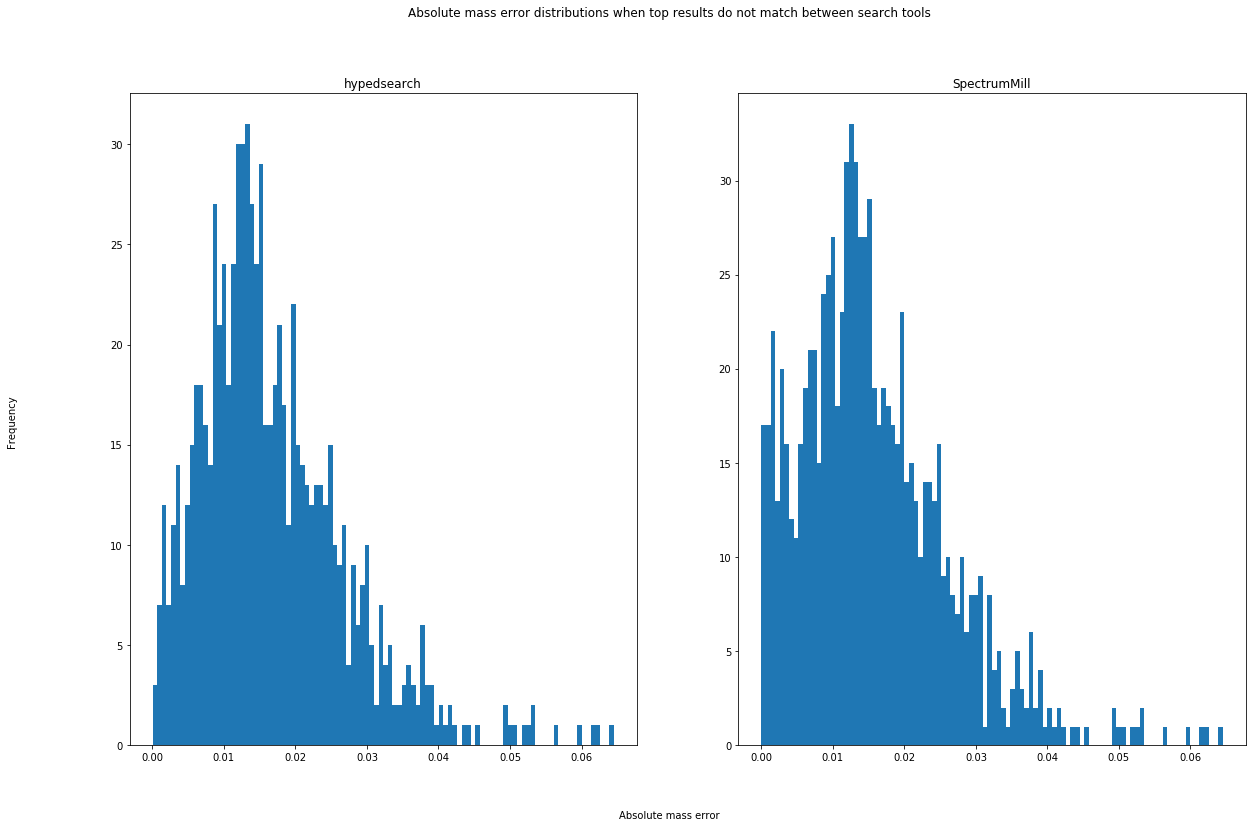

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

axes[0].hist([x[1] for x in all_hypedSearch_rank_tme], bins=100)
axes[0].set_title('hypedsearch')

axes[1].hist([x[1] for x in all_specMill_rank_tme], bins=100)
axes[1].set_title('SpectrumMill')

fig.suptitle('Absolute mass error distributions when top results do not match between search tools')
fig.text(0.5, 0.04, 'Absolute mass error', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

## Plot distribution of mass error per dataset

TypeError: 'AxesSubplot' object is not subscriptable

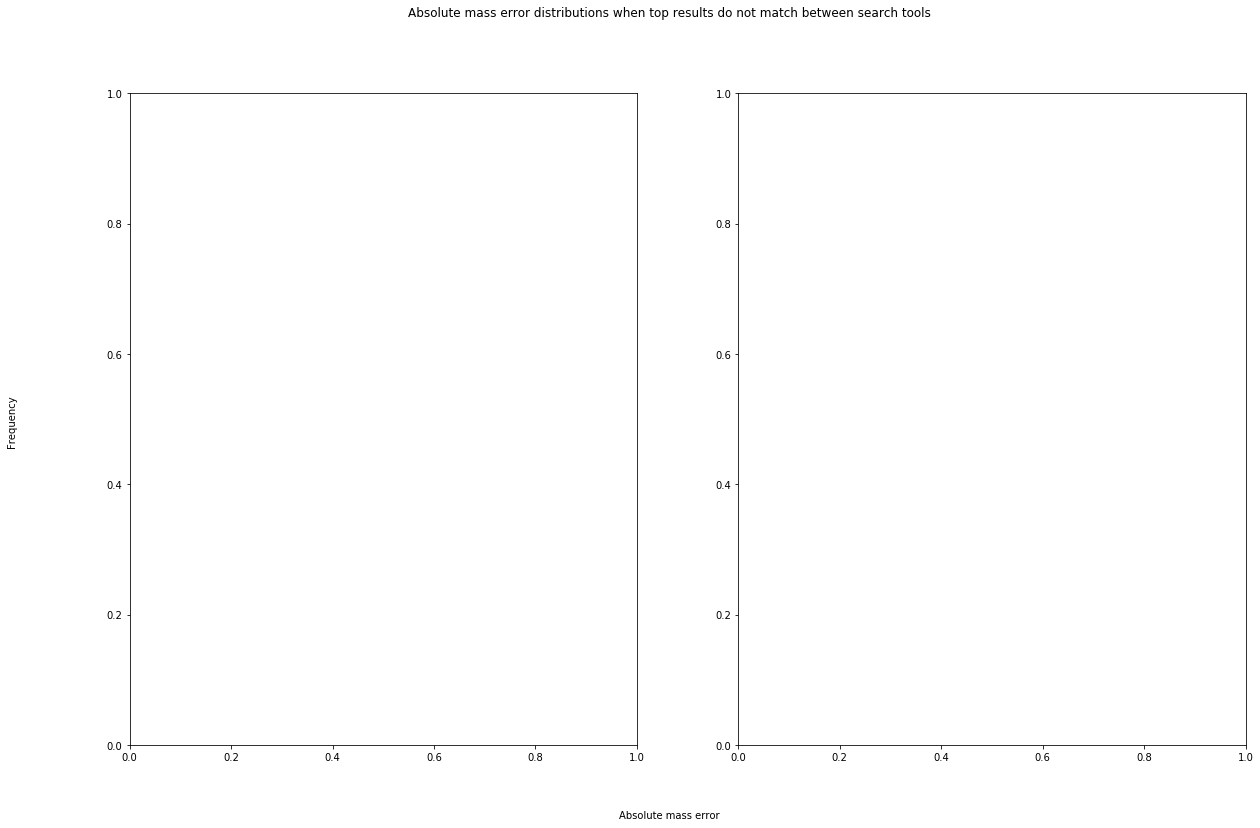

In [19]:
num_row = len(individual_hs_rank_tme)

fig, axes = plt.subplots(num_row, 2, figsize=(20, 12 * num_row))

fig.text(0.5, 0.04, 'Absolute mass error', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

fig.suptitle('Absolute mass error distributions when top results do not match between search tools')

for i, (hs_rank_tme, sm_rank_tme) in enumerate(zip(individual_hs_rank_tme, individual_sm_rank_tme)):

    dataset_name = datasets[i].highest_dir.split('/')[-2]
    
    axes[i][0].hist([x[1] for x in hs_rank_tme], bins=100)
    axes[i][0].set_title(f'hypedsearch on {dataset_name}')
    
    axes[i][1].hist([x[1] for x in sm_rank_tme], bins=100)
    axes[i][1].set_title(f'SpectrumMill on {dataset_name}')
    

## Correlate score and length

In [20]:
len_score = []

for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
    
    # BALB dataset id found in another location
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
    else:
        # index hypedSearch_results by the id value in key, value value['spectrum']
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    
    
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        hybrid = False
        
        if 'hybrid' in value['entry_name'].lower():
            hybrid = True
        
        correct_sequence = value['sequence']
        
        # if hybrid, replace L and I with B
        if hybrid:
            correct_sequence = correct_sequence.replace('L', 'B').replace('I', 'B')
        
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            continue 
            
        if not len(hypedSearch_results[key]['alignments']):
            continue
            
            
        len_score.append(
            (len(correct_sequence), max([x['total_score'] for x in hypedSearch_results[key]['alignments']]))
        )
                    
#         for i, alignment in enumerate(hypedSearch_results[key]['alignments']):
            
#             comp_sequence = alignment['sequence']
            
#             # bin it 
#             scores[alignment['total_score']].append(alignment)
            
#             # if hybrid, replace L and I with B
#             if hybrid:
#                 comp_sequence = comp_sequence.replace('L', 'B').replace('I', 'B')
            
#             if comp_sequence == correct_sequence:

#                 len_score.append(
#                     (len(comp_sequence.replace('-', '').replace('(', '').replace(')', '')), alignment['total_score'])
#                 )
    

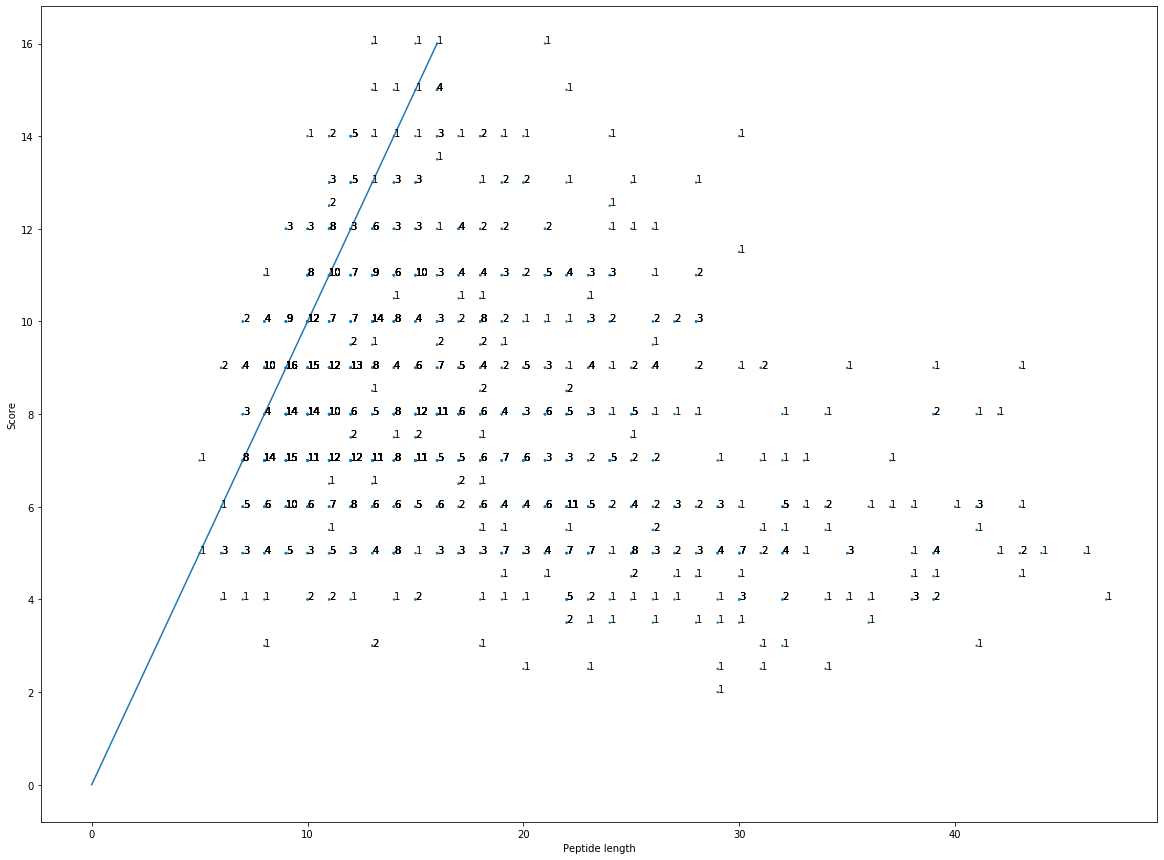

In [21]:
lens = [x[0] for x in len_score]
scores = [x[1] for x in len_score]

counts = defaultdict(lambda: 0)

for length, score in len_score:
    counts[(length, score)] += 1
    
plt.figure(figsize=(20, 15))

plt.scatter(lens, scores, s=[counts[(length, score)] for length_score in len_score])

for ls in len_score:
    plt.annotate(counts[ls], xy=ls)
plt.xlabel('Peptide length')
plt.ylabel('Score')

diag = [i for i in range(min(max(lens), max(scores)) + 1)]

plt.plot(diag, diag)

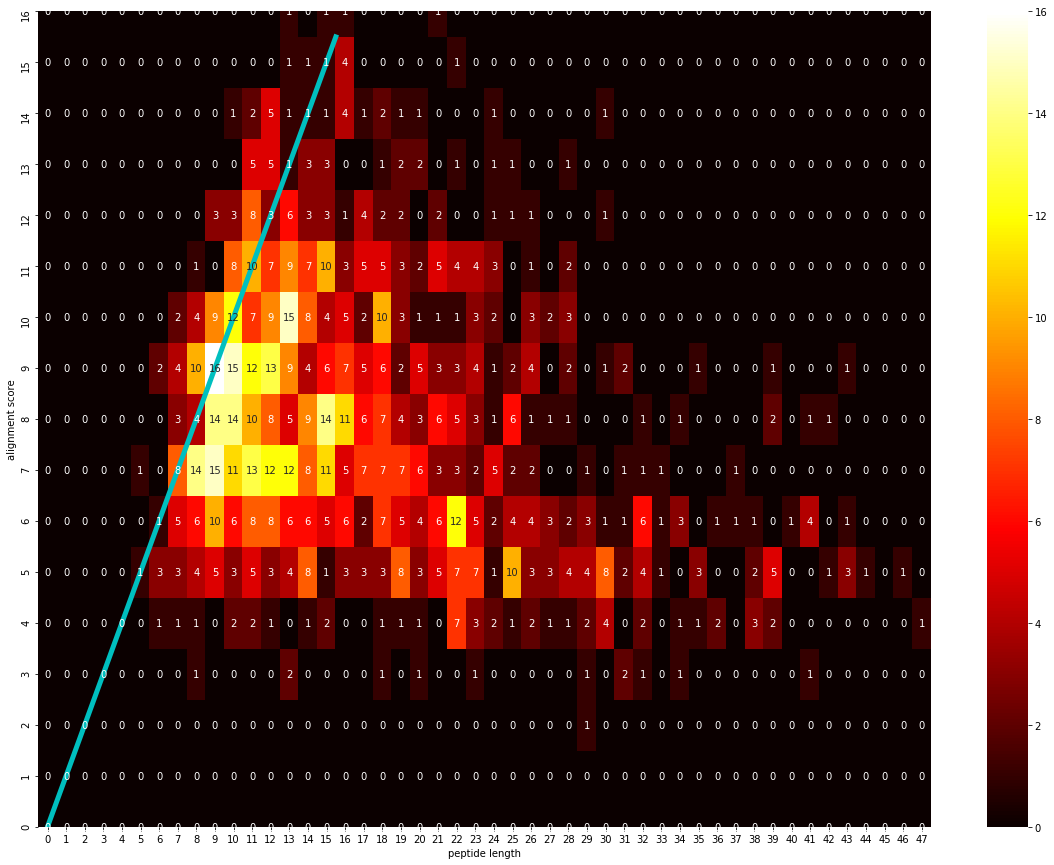

In [28]:
# heatmap instead
max_x = int(np.ceil(max(scores)))
max_y = max(lens)

xy = [[0 for _ in range(max_y + 1)] for _ in range(max_x + 1)]


for l, s in len_score:

    xy[int(np.ceil(s))][l] += 1
    
plt.figure(figsize=(20, 15))
    
ax = seaborn.heatmap(xy, cmap='hot', annot=True)
ax.invert_yaxis()

plt.xlabel('peptide length')
plt.ylabel('alignment score')

plt.plot(diag, diag, c='c', linewidth=5)

## Find out what a "good alignment" is
We want to be able to break when we have a good non hybrid alignment, so we need to see what high quality threshold we should use

What we should look at: 
1. percent abundance covered

### Percent abundance covered
Of the peaks that were matched, see how much of the total abundance was covered. Look at only the results where rank 1 of hypedsearch matched the result of SpectrumMill

In [23]:
def pac(entry: dict, ref_seq: str, ppm: int = 20) -> float:
    '''Calculate the percent abundance covered for a reference sequence, an entry (analogous
    to a Spectrum) with a certain ppm tolerance
    '''
    
    ref_spec = sorted(gen_spectra.gen_spectrum(ref_seq)['spectrum'])
    
    r_i, o_i = 0, 0
    
    matched_is = []
        
    while r_i < len(ref_spec) and o_i < len(entry['spectrum']['spectrum']):
        
        # get lower, upper
        da_tol = utils.ppm_to_da(ref_spec[r_i], ppm)
        
        if entry['spectrum']['spectrum'][o_i] < ref_spec[r_i] - da_tol:
            o_i += 1
            continue
            
        if entry['spectrum']['spectrum'][o_i] > ref_spec[r_i] + da_tol:
            r_i += 1
            continue
            
        matched_is.append(o_i)
        r_i += 1
        o_i += 1
        
    # go through all matched i's and sum the abundances
    matched_is_a = sum([entry['spectrum']['abundance'][i] for i in matched_is])
    
    return matched_is_a / sum([x for x in entry['spectrum']['abundance']])

In [26]:
scores_pac = []

for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
    
    # BALB dataset id found in another location
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
    else:
        # index hypedSearch_results by the id value in key, value value['spectrum']
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    
    
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        hybrid = False
        
        if 'hybrid' in value['entry_name'].lower():
            hybrid = True
        
        correct_sequence = value['sequence']
        
        # if hybrid, replace L and I with B
        if hybrid:
            correct_sequence = correct_sequence.replace('L', 'B').replace('I', 'B')
        
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            continue 
            
        if not len(hypedSearch_results[key]['alignments']):
            continue
            
            
        # get the rank (with ties) and then only continue if the specmil result is in hypedsearch
        share_seq = False
        
        if hybrid:
            share_seq= any([x['sequence'].replace('L', 'B').replace('I', 'B') == correct_sequence for x in hypedSearch_results[key]['alignments']])
        
        else: 
            share_seq= any([x['sequence'] == correct_sequence for x in hypedSearch_results[key]['alignments']])
            
        # if not share_seq, break
        if not share_seq:
            continue 
            
        hypedSearch_overlap = None
        
        # get the max score to see if the overlap is rank 0
        max_score = max([x['total_score'] for x in hypedSearch_results[key]['alignments']])
        
        # go through the results to find the overlap 
        for entry in hypedSearch_results[key]['alignments']:
            
            if hybrid:
                if entry['sequence'].replace('L', 'B').replace('I', 'B') == correct_sequence:
                    
                    # if the score is not max score, break
                    if entry['total_score'] < max_score:
                        break
                        
                    hypedSearch_overlap = entry
                    break
                    
            else:
                if entry['sequence'] == correct_sequence:
                    
                    # if the score is not max score, break
                    if entry['total_score'] < max_score:
                        break
                        
                    hypedSearch_overlap = entry
                    break
                    
        # if the overlaping sequence was not tied for first, skip
        if hypedSearch_overlap is None: 
            continue
                    
        hypedSearch_overlap['spectrum'] = hypedSearch_results[key]['spectrum']
        
        # now get pac and socre
        scores_pac.append((max_score, pac(hypedSearch_overlap, correct_sequence, tolerance)))
        
        if hybrid: 
            print(scores_pac[-1])

(7, 0.2917662901584019)
(11.5, 0.604055736865149)
(6.5, 0.3453924493376086)
(12.5, 0.6078577735683272)
(10, 0.48770927841900535)


Text(159.0, 0.5, 'alignment score')

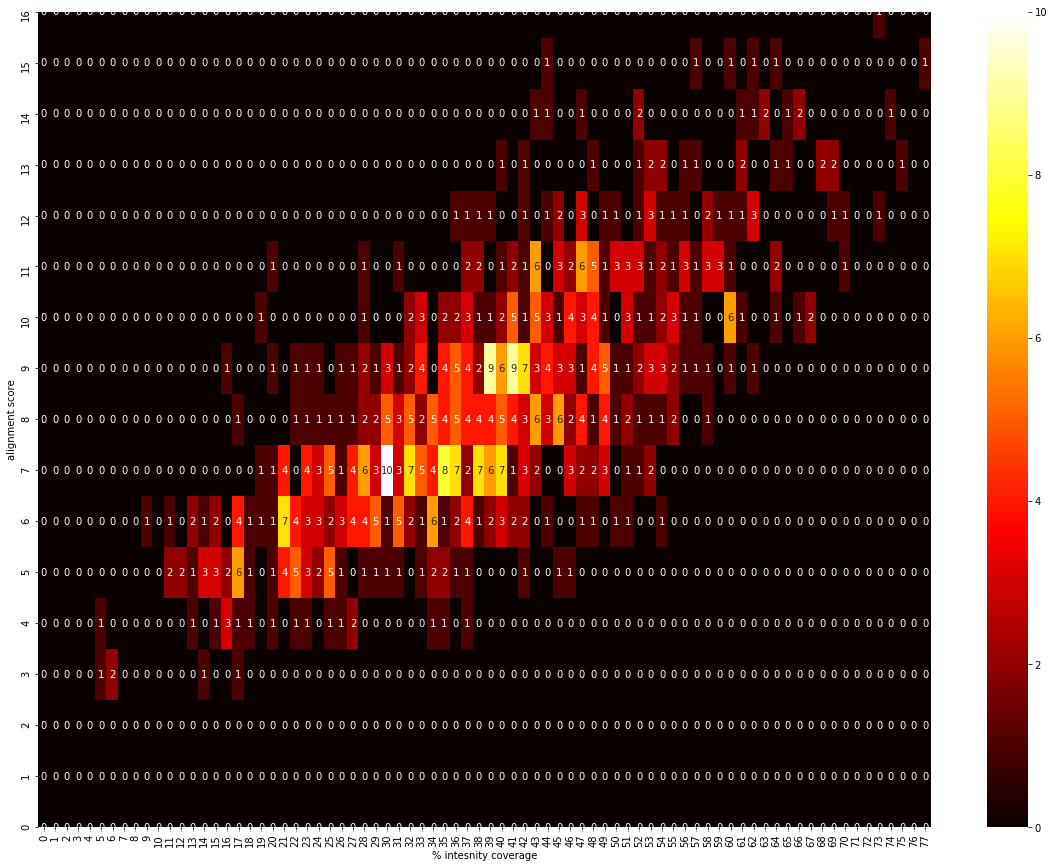

In [29]:
# now plot it
scores = [x[0] for x in scores_pac]
pacs = [x[1] * 100 for x in scores_pac]

max_x = int(np.ceil(max(scores)))
max_y = int(np.ceil(max(pacs)))

xy = [[0 for _ in range(max_y + 1)] for _ in range(max_x + 1)]

for s, p in scores_pac:
    xy[int(np.ceil(s))][int(np.ceil(p * 100))] += 1
    
plt.figure(figsize=(20, 15))
    
ax = seaborn.heatmap(xy, cmap='hot', annot=True)
ax.invert_yaxis()

plt.xlabel('% intesnity coverage')
plt.ylabel('alignment score')

# plt.plot(diag, diag, c='c', linewidth=5)